In [1]:
# Required libraries
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

In [2]:
def cir_em(T, n_steps, n_paths, kappa, theta, sigma, dW):
    """
    Generates CIR process using the Euler-Maruyama method.
    
    Parameters:
    T : float
        Time period.
    n_steps : int
        Number of time steps.
    n_paths : int
        Number of paths.
    kappa : float
        Mean reversion rate.
    theta : float
        Long-term mean.
    sigma : float
        Volatility parameter.
    dW : ndarray
        Brownian motion increments.

    Returns:
    ndarray
        Simulated CIR paths.
    """
    r_paths = np.ones((n_paths, n_steps+1))
    r_paths[:,0] = theta
    
    # Generate the CIR process using the Eurler-Maryuma explicit method
    for i in range(n_steps):
        r_paths[:, i+1] = r_paths[:,i] + (kappa * (theta - r_paths[:,i]) * T) + np.sqrt(r_paths[:,i]) * sigma * dW[:,i]
    return r_paths

# Simulate asset prices using geometric Brownian motions and Euler method
def simulate_gbm(mu, sigma, T, n_steps, n_paths, s0, dW):
    """
    Simulates asset prices using the geometric Brownian motion model.

    Parameters:
    mu : float
        Drift term.
    sigma : ndarray
        Volatility (can be time-varying).
    T : float
        Time period.
    n_steps : int
        Number of time steps.
    n_paths : int
        Number of paths.
    s0 : float
        Initial asset price.
    dW : ndarray
        Brownian motion increments.

    Returns:
    ndarray
        Simulated asset price paths.
    """
    # Initialize the parameters
    s_paths = np.zeros((n_paths, n_steps+1))
    s_paths[:,0] = s0

    # Generate asset price process using correlated Brownian motions
    for i in range(n_steps):
        s_paths[:, i+1] = s_paths[:,i] + (mu * s_paths[:,i] * T) + (sigma[:,i] * s_paths[:,i] * dW[:,i])
    
    return s_paths

def call_option_price(S, K, r, q, T, sigma):
    """
    Calculates the call option prices and deltas using the Black-Scholes formula.

    Parameters:
    S : float
        Current asset price.
    K : float
        Strike price.
    r : float
        Risk-free interest rate.
    q : float
        Dividend yield.
    T : float
        Time to maturity.
    sigma : float
        Volatility of the underlying asset.

    Returns:
    tuple
        Call option prices and deltas.
    """
    d1 = (np.log(S / K) + (r - q + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-q * T) * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    call_delta = stats.norm.cdf(d1)
    return call_price, call_delta

def call_option_delta_hedge_process(number_of_shares, hedging_frequency, risk_free_rate, s_paths, option_prices, option_deltas, n_steps, n_paths):
    """
    Simulates the delta hedge process for a portfolio of call options.

    Parameters:
    number_of_shares : int
        Number of shares.
    hedging_frequency : float
        Frequency of hedging.
    risk_free_rate : float
        Risk-free interest rate.
    s_paths : ndarray
        Simulated asset price paths.
    option_prices : ndarray
        Call option prices.
    option_deltas : ndarray
        Call option deltas.
    n_steps : int
        Number of time steps.
    n_paths : int
        Number of paths.

    Returns:
    tuple
        Portfolio value and hedge interest.
    """
    value = np.zeros((n_paths, n_steps+1))
    value[:,0] = option_prices[:,0] * number_of_shares
    hedge_interest = np.zeros((n_paths, n_steps+1))
    hedge_interest[:,0] = value[:,0] - number_of_shares * option_deltas[:,0] * s_paths[:,0]

    # Delta hedge process
    for i in range(n_steps):
        value[:,i + 1] = value[:,i] + (option_deltas[:,i] * (s_paths[:,i + 1] - s_paths[:,i])) + \
            hedge_interest[:,i] * (np.exp((hedging_frequency / n_steps) * risk_free_rate) - 1)
        hedge_interest[:,i + 1] = value[:,i + 1] - option_deltas[:,i + 1] * s_paths[:,i + 1]

    return value, hedge_interest

def calc_prop_above_below_rt_s_paths_portfolio(s_paths_gbm, K_threshold, R_t):
    """
    Calculate proportions of paths above and below a given threshold relative to a reference value.

    This function computes the proportions of paths in a geometric Brownian motion (GBM) model
    that remain either above or below a specified threshold relative to a reference value (R_t).

    Inputs:
    - s_paths_gbm: Array of simulated asset price paths (GBM) over time.
    - K_threshold: Array of threshold values relative to R_t.
    - R_t: Reference value used for threshold computation.

    Outputs:
    - prop_below_rt: Array of proportions of paths below the threshold for each K_threshold value.
    - prop_above_rt: Array of proportions of paths above the threshold for each K_threshold value.
    """
        
    # Initialize arrays to store proportions
    prop_above_rt = np.zeros(len(K_threshold))
    prop_below_rt = np.zeros(len(K_threshold))
    
    # Calculate the mask once outside the loop to avoid repeated computation
    log_s_paths_gbm = np.log1p(s_paths_gbm)
    
    for i in range(len(K_threshold)):
        # Compute the threshold for the current K_threshold value
        threshold = R_t - K_threshold[i]
        
        # Create a mask indicating whether each path is above the threshold
        above_rt_mask = log_s_paths_gbm > threshold
        
        # Check if each path remains above the threshold for all time steps
        path_complete_mask = np.all(above_rt_mask[:, :-1], axis=1)
        
        # Calculate proportion of paths above and below the threshold
        prop_above_rt[i] = np.mean(path_complete_mask)
        prop_below_rt[i] = 1 - prop_above_rt[i]  # All paths sum to 1
        
    return prop_below_rt, prop_above_rt

def buy_hold_portfolio_payoff_T(s, s0, r, T):
    """
    Calculate the payoff of a buy-and-hold portfolio at time T.

    Parameters:
    s : ndarray
        Simulated asset prices at each time step for multiple paths.
    s0 : float
        Initial asset price.
    r : float
        Risk-free rate.
    T : floatTotal time horizon.

    Returns:
        ndarray: Payoff of the buy-and-hold portfolio at time T for each path.
    """
    return s[:, -1] - s0 * np.exp(r * T)


def buy_hold_portfolio_payoff_T_2(s, s0, r, T, n_steps):
    """
    Calculate the payoff of a buy-and-hold portfolio at half of the total time horizon.

    Parameters:
    s : ndarray
        Simulated asset prices at each time step for multiple paths.
    s0 : float 
        Initial asset price.
    r : float
        Risk-free rate.
    T : float 
        Total time horizon.
    n_steps : int
        Number of time steps.

    Returns:
        ndarray: Payoff of the buy-and-hold portfolio at half of the total time horizon for each path.
    """
    return s[:, n_steps // 2] - s0 * np.exp(r * T / 2)


def long_call_portfolio_payoff_T(hedged_p, call_p, r, t):
    """
    Calculate the payoff of a long call portfolio at time t.

    Parameters:
    hedged_p : ndarray
        Hedged portfolio values at each time step for multiple paths.
    call_p : ndarray
        Call option prices at each time step for multiple paths.
    r : float
        Risk-free rate.
    t : float
        Time horizon.

    Returns:
        ndarray: Payoff of the long call portfolio at time t for each path.
    """
    return hedged_p[:, -1] - call_p[:, 1] * np.exp(r * t)


def long_call_portfolio_payoff_T_2(hedged_p, call_p, r, t, n_steps):
    """
    Calculate the payoff of a long call portfolio at half of the total time horizon.

    Parameters:
    hedged_p : ndarray
        Hedged portfolio values at each time step for multiple paths.
    call_p : ndarray 
        Call option prices at each time step for multiple paths.
    r : float
        Risk-free rate.
    t float
        Total time horizon.
    n_steps : int
        Number of time steps.

    Returns:
        ndarray: Payoff of the long call portfolio at half of the total time horizon for each path.
    """
    return hedged_p[:, n_steps // 2] - call_p[:, 1] * np.exp(r * t / 2)


def short_call_portfolio_payoff_T(hedged_p, call_p, t):
    """
    Calculate the payoff of a short call portfolio at time t.

    Parameters:
    hedged_p : ndarray 
        Hedged portfolio values at each time step for multiple paths.
    call_p : ndarray
        Call option prices at each time step for multiple paths.
    t : int
        Time step index.

    Returns:
        ndarray: Payoff of the short call portfolio at time t for each path.
    """
    return hedged_p[:, t-1] - call_p[:, t-1]


def short_call_portfolio_payoff_T_2(hedged_p, call_p, t):
    """
    Calculate the payoff of a short call portfolio at half of the total time horizon.

    Parameters:
    hedged_p : ndarray
        Hedged portfolio values at each time step for multiple paths.
    call_p : ndarray
        Call option prices at each time step for multiple paths.
    t : int
        Total time step index.

    Returns:
        ndarray: Payoff of the short call portfolio at half of the total time horizon for each path.
    """
    return hedged_p[:, t // 2] - call_p[:, t // 2]


def V_phi_omega_T(port_value):
    """
    Calculate the new risk measure V_phi(omega, T).
    
    Parameters:
    port_value : float 
        Filtered portfolio values
    
    Returns:
        float: The negative minimum value of the portfolio values.
    """
    # Calculate and return the negative minimum value of the filtered portfolio payoff
    return -1 * np.min(port_value)


def V_phi_VaR(p_t, a):
    """
    Calculate the Value at Risk (VaR) at time T for the given portfolio values.
    
    Parameters:
    - portfolio_value_t : numpy.ndarray
        Array of portfolio values at time T.
    - alpha : float 
        Confidence level for VaR calculation (e.g., 5 for 5% VaR).
    
    Returns:
    - float: The negative value at risk at the specified confidence level.
    """
    # Calculate and return the negative VaR at the specified confidence level
    return -1 * np.percentile(p_t, a)

def calculate_prop_k1_k2(log_s_paths, cir_paths, threshold_k1_values, threshold_k2_values, threshold_r_t_base, mean_vol):
    """
    Calculate the proportion of paths that are above the threshold for k1 and below the threshold for k2.
    
    Parameters:
    - log_s_paths (numpy.ndarray): Logarithm of the simulated asset paths (log(S(t))).
    - cir_paths (numpy.ndarray): Simulated CIR process paths representing volatility.
    - threshold_k1_values (list or numpy.ndarray): List of k1 threshold values to evaluate.
    - threshold_k2_values (list or numpy.ndarray): List of k2 threshold values to evaluate.
    - threshold_r_t_base (float): Base threshold value for the asset paths.
    - mean_vol (float): Mean volatility to use as a base for k2 thresholds.
    
    Returns:
    - numpy.ndarray: Matrix of proportions where each element (i, j) represents the proportion 
                     of paths that are above the k1 threshold and below the k2 threshold.
    """
    
    # Initialize the matrix to store results
    threshold_k1_k2_matrix = np.zeros((len(threshold_k1_values), len(threshold_k2_values)))
    
    # Iterate over all k1 values
    for i, k1 in enumerate(threshold_k1_values):
        # Calculate the adjusted threshold for k1
        threshold_r_t_k1 = threshold_r_t_base - k1
        
        # Iterate over all k2 values
        for j, k2 in enumerate(threshold_k2_values):
            # Calculate the adjusted threshold for k2
            threshold_v_t_k2 = mean_vol + k2
            
            # Create masks for the conditions
            # Mask where log(S(t)) is above the k1 threshold
            above_rt_mask_k1 = log_s_paths > threshold_r_t_k1
            
            # Mask where CIR paths are below the k2 threshold
            below_vt_mask_k2 = cir_paths < threshold_v_t_k2
            
            # Combine masks to get a single mask where both conditions are satisfied
            combined_mask = above_rt_mask_k1 & below_vt_mask_k2
            
            # Check if each path remains above the k1 threshold and below the k2 threshold for all time steps
            path_complete_mask = np.all(combined_mask[:, :-1], axis=1)
            
            # Calculate proportion of paths that do not satisfy the combined condition
            threshold_k1_k2_matrix[i, j] = 1 - np.mean(path_complete_mask)
    
    return threshold_k1_k2_matrix

In [3]:
np.random.seed(123)  # Set seed for reproducibility

# Time variables
T = 1.0  # Total time
n_steps = 250  # Number of time steps
n_paths = 5000  # Number of simulation paths
dt = T / (n_steps * T)  # Time step size
x_axis_t = np.arange(0, T + dt, dt)  # Time points for x-axis

# CIR process variables
kappa = 2  # Mean reversion speed
theta = 0.04  # Long-term mean
sigma = 0.1  # Volatility of volatility

# Asset price variables
s0 = 100  # Initial asset price
log_s0 = np.log1p(s0)  # Log of initial asset price
mu = 0.05  # Drift of asset price
long_term_vol = np.round(np.sqrt(theta), 2)  # Long-term volatility

# Option pricing variables
risk_free_rate = 0.05  # Risk-free interest rate
strike = 110  # Strike price of the option
dividend = 0  # Dividend yield
number_of_shares = 1  # Number of shares
hedging_frequency = 1  # Frequency of hedging
dt_seq = np.flip(np.arange(0, T + dt, hedging_frequency / n_steps))  # Time steps for option pricing
dt_seq = dt_seq[np.newaxis,:]  # Ensure dt_seq is 2D for broadcasting

# Create correlated Brownian motion
dZ = np.random.normal(loc=0, scale=np.sqrt(dt), size=(n_paths, n_steps))  # Standard normal increments for dZ
dW1 = np.random.normal(loc=0, scale=np.sqrt(dt), size=(n_paths, n_steps))  # Standard normal increments for dW1

# Generate the CIR process for stochastic volatility
cir_vol_paths = cir_em(T=dt, n_steps=n_steps, n_paths=n_paths, kappa=kappa, theta=theta, sigma=sigma, dW=dW1)

# Calculate stochastic volatility
stoc_vol = np.sqrt(cir_vol_paths)

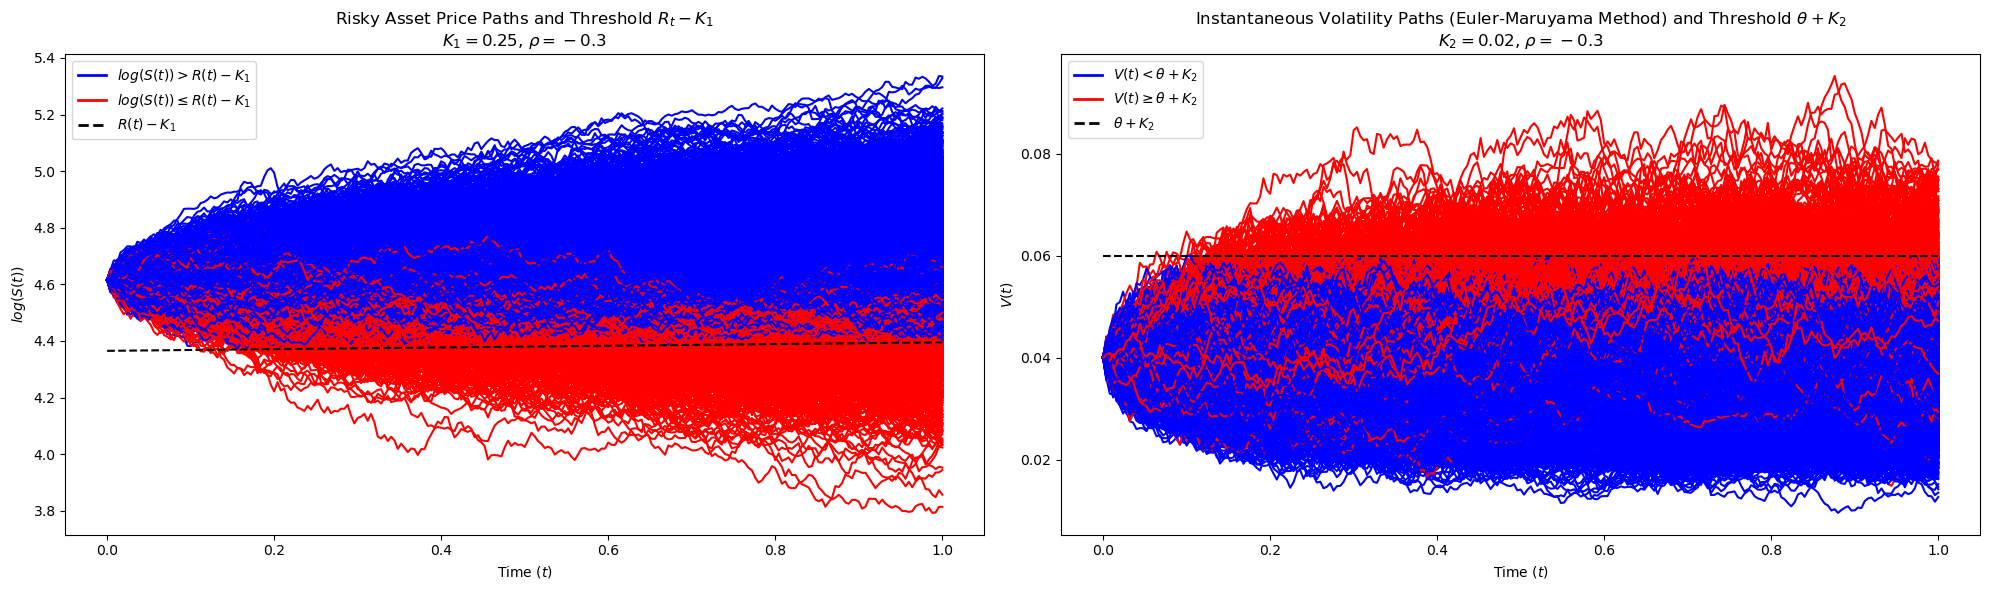

In [4]:
# Buy-and-Hold portfolio with one threshold
rho = -0.3  # Correlation coefficient
single_k1_threshold = 0.25  # Threshold value for k1
dW2 = (rho * dW1) + (np.sqrt(1 - rho**2) * dZ)  # Generate correlated Brownian motion dW2

# Buy-and-Hold portfolio with two thresholds test
single_k1_threshold = 0.25  # Threshold value for k1
single_k2_threshold = 0.02  # Threshold value for k2

# Generate stochastic asset prices using geometric Brownian motion with the correlated dW2
s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)

# Calculate the thresholds
threshold_r_t_k1 = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps+1) * dt) + log_s0 - single_k1_threshold
threshold_v_t_k2 = np.repeat(theta, len(threshold_r_t_k1)) + single_k2_threshold

# Create masks for the conditions where asset price paths are above/below the thresholds
above_rt_mask_k1 = np.zeros((n_paths, n_steps+1))
below_vt_mask_k2 = np.zeros((n_paths, n_steps+1))
for i in range(n_paths):
    above_rt_mask_k1[i, :] = np.log1p(s_paths_gbm[i,:]) > threshold_r_t_k1
    below_vt_mask_k2[i, :] = cir_vol_paths[i,:] < threshold_v_t_k2

# Set up the figure with two subplots side-by-side
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Adding a subtitle with the standard error of sample mean
subtitle_text_1 = f"$K_{1} = {single_k1_threshold}$, $\rho = {rho}$"

# First subplot for Risky Asset Price Paths and Threshold R_t - K1
for i in range(n_paths):
    color = 'blue' if above_rt_mask_k1[i].all() else 'red'  # Color based on if path stays above the threshold
    label_text = f'Path {i+1} (Always Above $K_1$)' if above_rt_mask_k1[i].all() else f'Path {i+1} (Hits Below $K_1$)'
    axs[0].plot(x_axis_t, np.log1p(s_paths_gbm[i]), label=label_text, color=color)

axs[0].plot(x_axis_t, threshold_r_t_k1, color='black', label=r'$R(t) - K_{1}$', linestyle='--')
axs[0].set_xlabel('Time $(t)$')
axs[0].set_ylabel('$log(S(t))$')
axs[0].set_title(f'Risky Asset Price Paths and Threshold $R_t - K_1$\n$K_1 = {single_k1_threshold}$, $\\rho = {rho}$')

# Custom legend for the first subplot
legend_elements_1 = [
    plt.Line2D([0], [0], color='blue', lw=2, label='$log(S(t)) > R(t) - K_{1}$'),
    plt.Line2D([0], [0], color='red', lw=2, label='$log(S(t)) \leq R(t) - K_{1}$'),
    plt.Line2D([0], [0], color='black', linestyle='--', lw=2, label=r'$R(t) - K_{1}$')
]
axs[0].legend(handles=legend_elements_1)

# Second subplot for Instantaneous Volatility Paths with Euler-Maruyama with θ + K2 threshold
for i in range(n_paths):
    color = 'blue' if below_vt_mask_k2[i].all() else 'red'  # Color based on if path stays below the threshold
    label_text = f'Path {i+1} (less than $\\theta + K_{2}$)' if below_vt_mask_k2[i].all() else f'Path {i+1} (greater than or equal to $\\theta + K_{2}$)'
    axs[1].plot(x_axis_t, cir_vol_paths[i], label=label_text, color=color)

axs[1].plot(x_axis_t, threshold_v_t_k2, color='black', label='$\\theta + K_{2}$', linestyle='--')
axs[1].set_xlabel('Time $(t)$')
axs[1].set_ylabel('$V(t)$')
axs[1].set_title(f'Instantaneous Volatility Paths (Euler-Maruyama Method) and Threshold $\\theta + K_{2}$\n$K_2 = {single_k2_threshold}$, $\\rho = {rho}$')

# Custom legend for the second subplot
legend_elements_2 = [
    plt.Line2D([0], [0], color='blue', lw=2, label='$V(t) < \\theta + K_{2}$'),
    plt.Line2D([0], [0], color='red', lw=2, label='$V(t) \geq \\theta + K_{2}$'),
    plt.Line2D([0], [0], color='black', linestyle='--', lw=2, label='$\\theta + K_{2}$')
]
axs[1].legend(handles=legend_elements_2)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


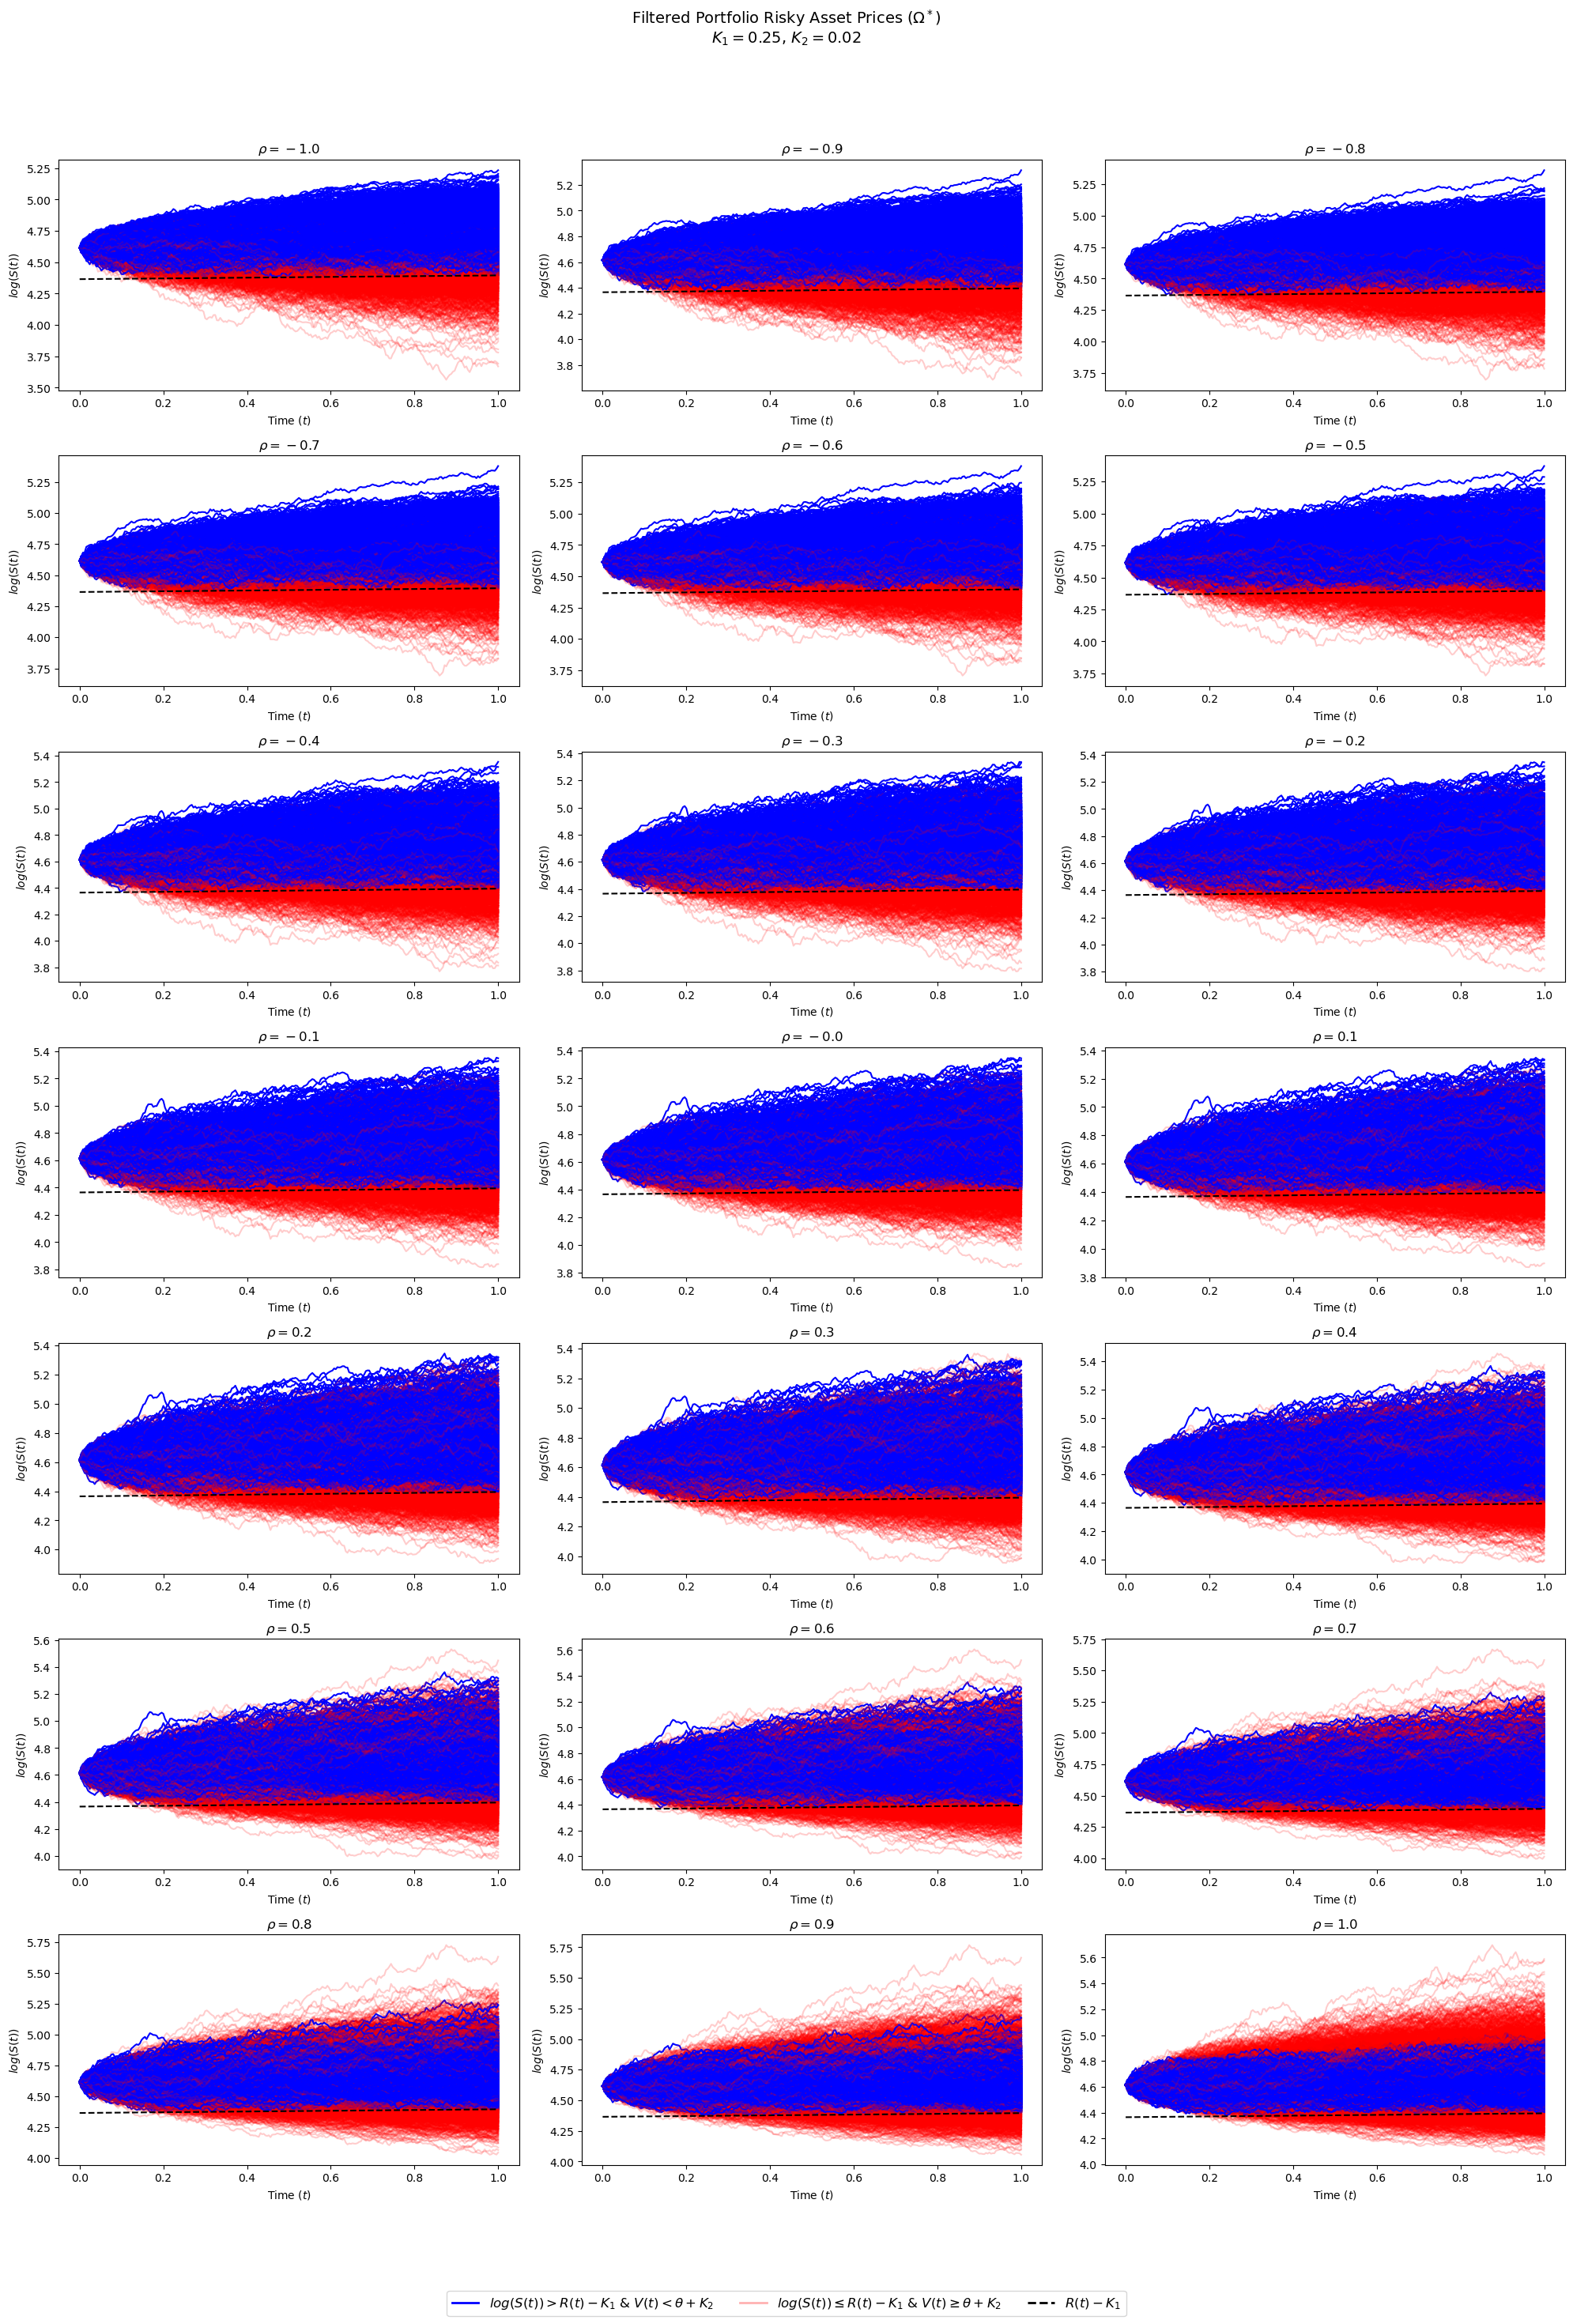

In [5]:
# Buy-and-Hold portfolio with two thresholds test
single_k1_threshold = 0.25  # Threshold value for k1
single_k2_threshold = 0.02  # Threshold value for k2
rho_values = np.arange(-1, 1.1, 0.1)  # rho from -1 to 1 with step 0.1

# Calculate thresholds for asset price and volatility
threshold_r_t_k1 = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps + 1) * dt) + log_s0 - single_k1_threshold
threshold_v_t_k2 = np.repeat(theta, len(threshold_r_t_k1)) + single_k2_threshold

# Set up the grid of plots (7 rows, 3 columns) for each value of rho
fig, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()

for idx, rho in enumerate(rho_values):
    # Correlated Brownian motion increments for dW2
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * dZ
    
    # Simulate the Geometric Brownian Motion paths using dW2
    s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
    
    # Create masks for the conditions (above k1 threshold and below k2 threshold)
    above_rt_mask_k1 = np.zeros((n_paths, n_steps+1), dtype=bool)
    below_vt_mask_k2 = np.zeros((n_paths, n_steps+1), dtype=bool)
    for i in range(n_paths):
        above_rt_mask_k1[i, :] = np.log1p(s_paths_gbm[i,:]) > threshold_r_t_k1
        below_vt_mask_k2[i, :] = cir_vol_paths[i,:] < threshold_v_t_k2

    # Combine masks to get a single mask where both conditions are satisfied
    combined_mask = above_rt_mask_k1 & below_vt_mask_k2

    # Plotting
    ax = axes[idx]
    for i in range(n_paths):
        if combined_mask[i].all():
            color = 'blue'
            alpha = 1.0  # Fully opaque for paths that meet both conditions
        else:
            color = 'red'
            alpha = 0.2  # More transparent for paths that don't meet both conditions
        ax.plot(x_axis_t, np.log1p(s_paths_gbm[i]), color=color, alpha=alpha)
    
    ax.plot(x_axis_t, threshold_r_t_k1, color='black', linestyle='--', label=r'$R(t) - K_{1}$')  # Plot threshold R(t) - K1
    ax.set_xlabel('Time $(t)$')
    ax.set_ylabel('$log(S(t))$')
    ax.set_title(f'$\\rho = {rho:.1f}$')

# Add a big title
fig.suptitle(f'Filtered Portfolio Risky Asset Prices ($\Omega^*$)\n$K_1 = {single_k1_threshold}$, $K_2 = {single_k2_threshold}$', fontsize=14)

# Create a single legend for all subplots
blue_line = plt.Line2D([0], [0], color='blue', lw=2, label='$log(S(t)) > R(t) - K_{1}$ & $V(t) < \\theta + K_{2}$')
red_line = plt.Line2D([0], [0], color='red', lw=2, alpha=0.3, label='$log(S(t)) \leq R(t) - K_{1}$ & $V(t) \geq \\theta + K_{2}$')
black_line = plt.Line2D([0], [0], color='black', linestyle='--', lw=2, label=r'$R(t) - K_{1}$')

fig.legend(handles=[blue_line, red_line, black_line], loc='upper center', ncol=3, fontsize='large', bbox_to_anchor=(0.5, 0.02))

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [6]:
# Asset price with two thresholds 

# Define ranges for threshold values k1 and k2
threshold_k1_values = np.linspace(0, 1.0, 100)  # 100 values from 0 to 1.0 for k1
threshold_k2_values = np.linspace(0, 0.1, 100)  # 100 values from 0 to 0.1 for k2
rho = -0.3  # Correlation coefficient

# Correlated Brownian motion increments for dW2
dW2 = rho * dW1 + np.sqrt(1 - rho**2) * dZ

# Simulate the Geometric Brownian Motion paths using dW2
s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
log_s_paths_gbm = np.log1p(s_paths_gbm)  # Logarithm of the simulated asset price paths

# Calculate the base threshold for R(t) - k1 only once
threshold_r_t_base = np.log1p(s0) + (mu - (1/2 * np.sqrt(theta)**2)) * np.linspace(0, T, n_steps + 1)

# Calculate the proportion of paths below the thresholds for each combination of k1 and k2
threshold_k1_k2_matrix = calculate_prop_k1_k2(
    log_s_paths=log_s_paths_gbm,          # Logarithm of simulated asset price paths
    cir_paths=cir_vol_paths,              # CIR process paths for stochastic volatility
    threshold_k1_values=threshold_k1_values,  # Array of k1 threshold values
    threshold_k2_values=threshold_k2_values,  # Array of k2 threshold values
    threshold_r_t_base=threshold_r_t_base,    # Base threshold R(t) - k1
    mean_vol=theta                           # Mean reversion level for volatility
)

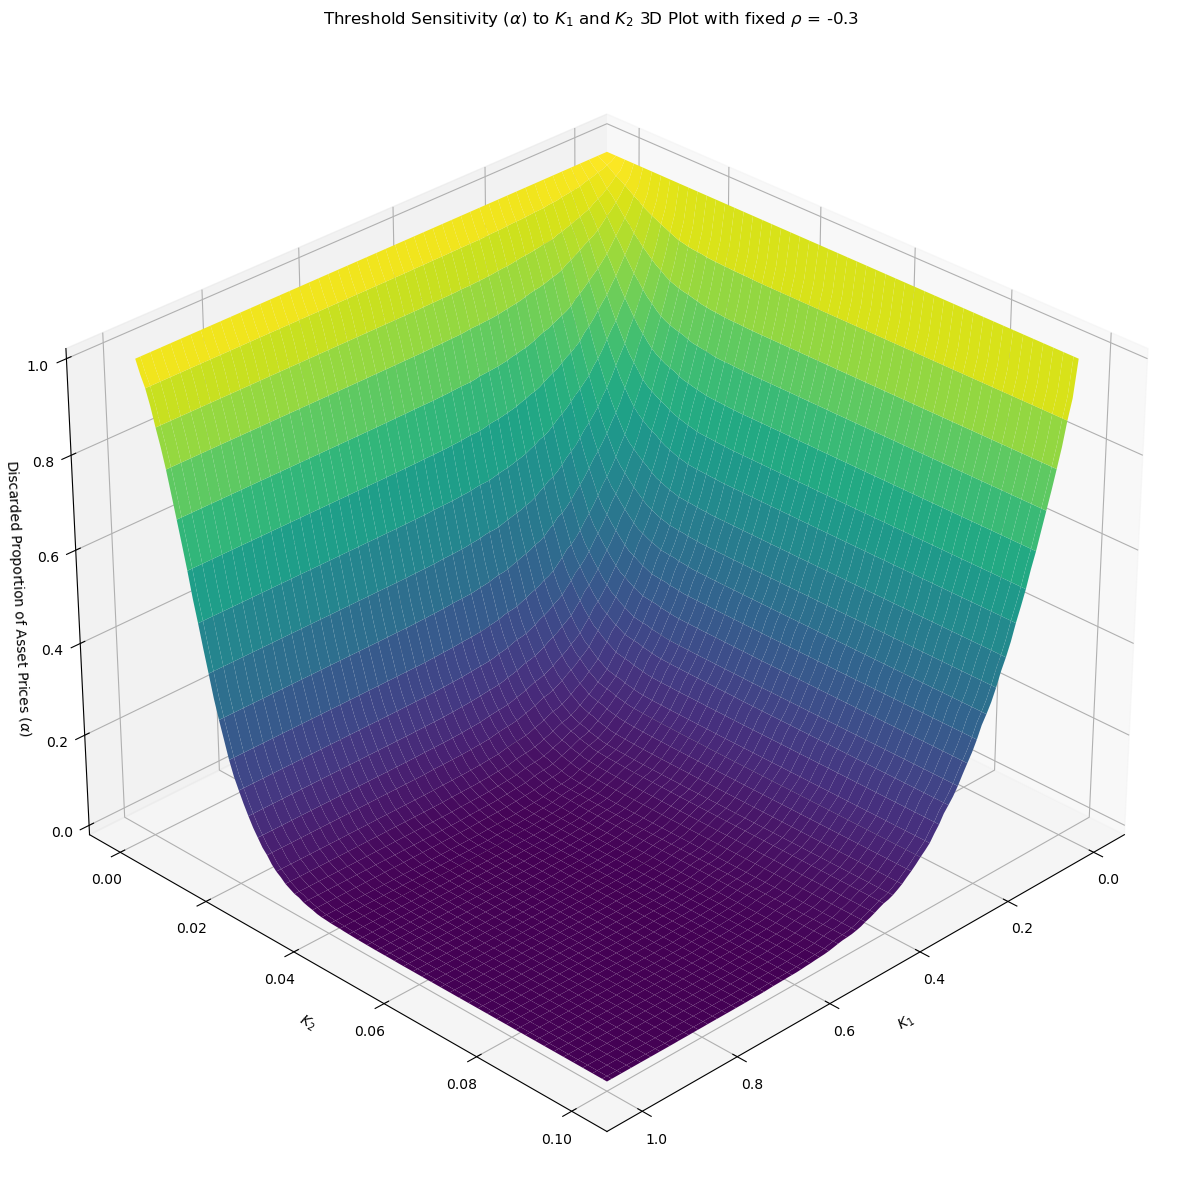

In [7]:
# Plotting the matrix as a mesh plot

# Create a new figure for the 3D plot
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for threshold values
X, Y = np.meshgrid(threshold_k1_values, threshold_k2_values)  # Meshgrid for K1 and K2 values
Z = threshold_k1_k2_matrix.T  # Transpose the matrix to match the meshgrid dimensions

# Plot the surface using the meshgrid and the matrix values
ax.plot_surface(X, Y, Z, cmap='viridis')  # Create a surface plot with the 'viridis' colormap

# Set axis labels and title for the plot
ax.set_xlabel('$K_1$')  # Set x-axis label
ax.set_ylabel('$K_2$')  # Set y-axis label
ax.set_zlabel('Discarded Proportion of Asset Prices $(\\alpha)$')  # Set z-axis label
ax.set_title(f'Threshold Sensitivity ($\\alpha$) to $K_{1}$ and $K_{2}$ 3D Plot with fixed $\\rho$ = {rho}')  # Set plot title

# Rotate the plot 45 degrees on the x-axis for better visualization
ax.view_init(elev=30, azim=45)  # Set elevation and azimuthal angle for the plot

# Show the plot
plt.show()  # Display the plot

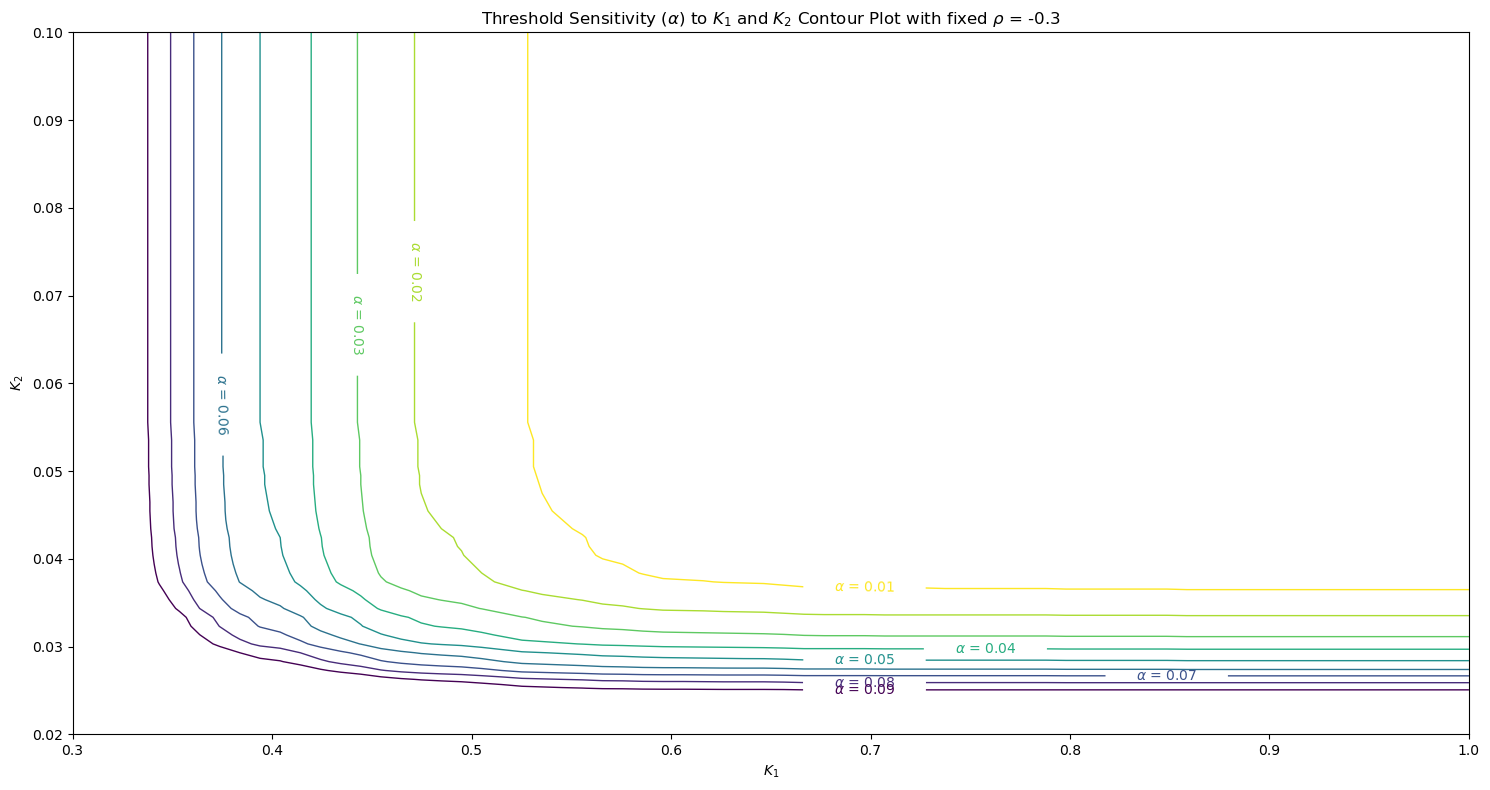

In [8]:
# Plotting the contour plot

# Create a new figure and axis for the contour plot
fig, ax = plt.subplots(figsize=(15, 8))

# Create meshgrid for threshold values
X, Y = np.meshgrid(threshold_k1_values, threshold_k2_values)  # Meshgrid for K1 and K2 values
Z = threshold_k1_k2_matrix.T  # Transpose the matrix to match the meshgrid dimensions

# Contour plot with highlighted alpha values
alpha_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]  # Alpha values to highlight
contour_highlight = ax.contour(X, Y, Z, levels=alpha_values, cmap='viridis_r', linewidths=1)  # Create contour plot
ax.clabel(contour_highlight, inline=1, fontsize=10, fmt={val: f'$\\alpha$ = {val:.2f}' for val in alpha_values})  # Add labels to contours

# Set axis labels and title for the plot
ax.set_xlabel('$K_1$')  # Set x-axis label
ax.set_ylabel('$K_2$')  # Set y-axis label
ax.set_title(f'Threshold Sensitivity ($\\alpha$) to $K_1$ and $K_2$ Contour Plot with fixed $\\rho$ = {rho}')  # Set plot title

# Set x and y limits for the plot
ax.set_xlim(0.3, 1)  # Set x-axis limits
ax.set_ylim(0.02, 0.1)  # Set y-axis limits

# Adjust layout for better spacing
plt.tight_layout()  # Adjust layout

# Show the plot
plt.show()  # Display the plot

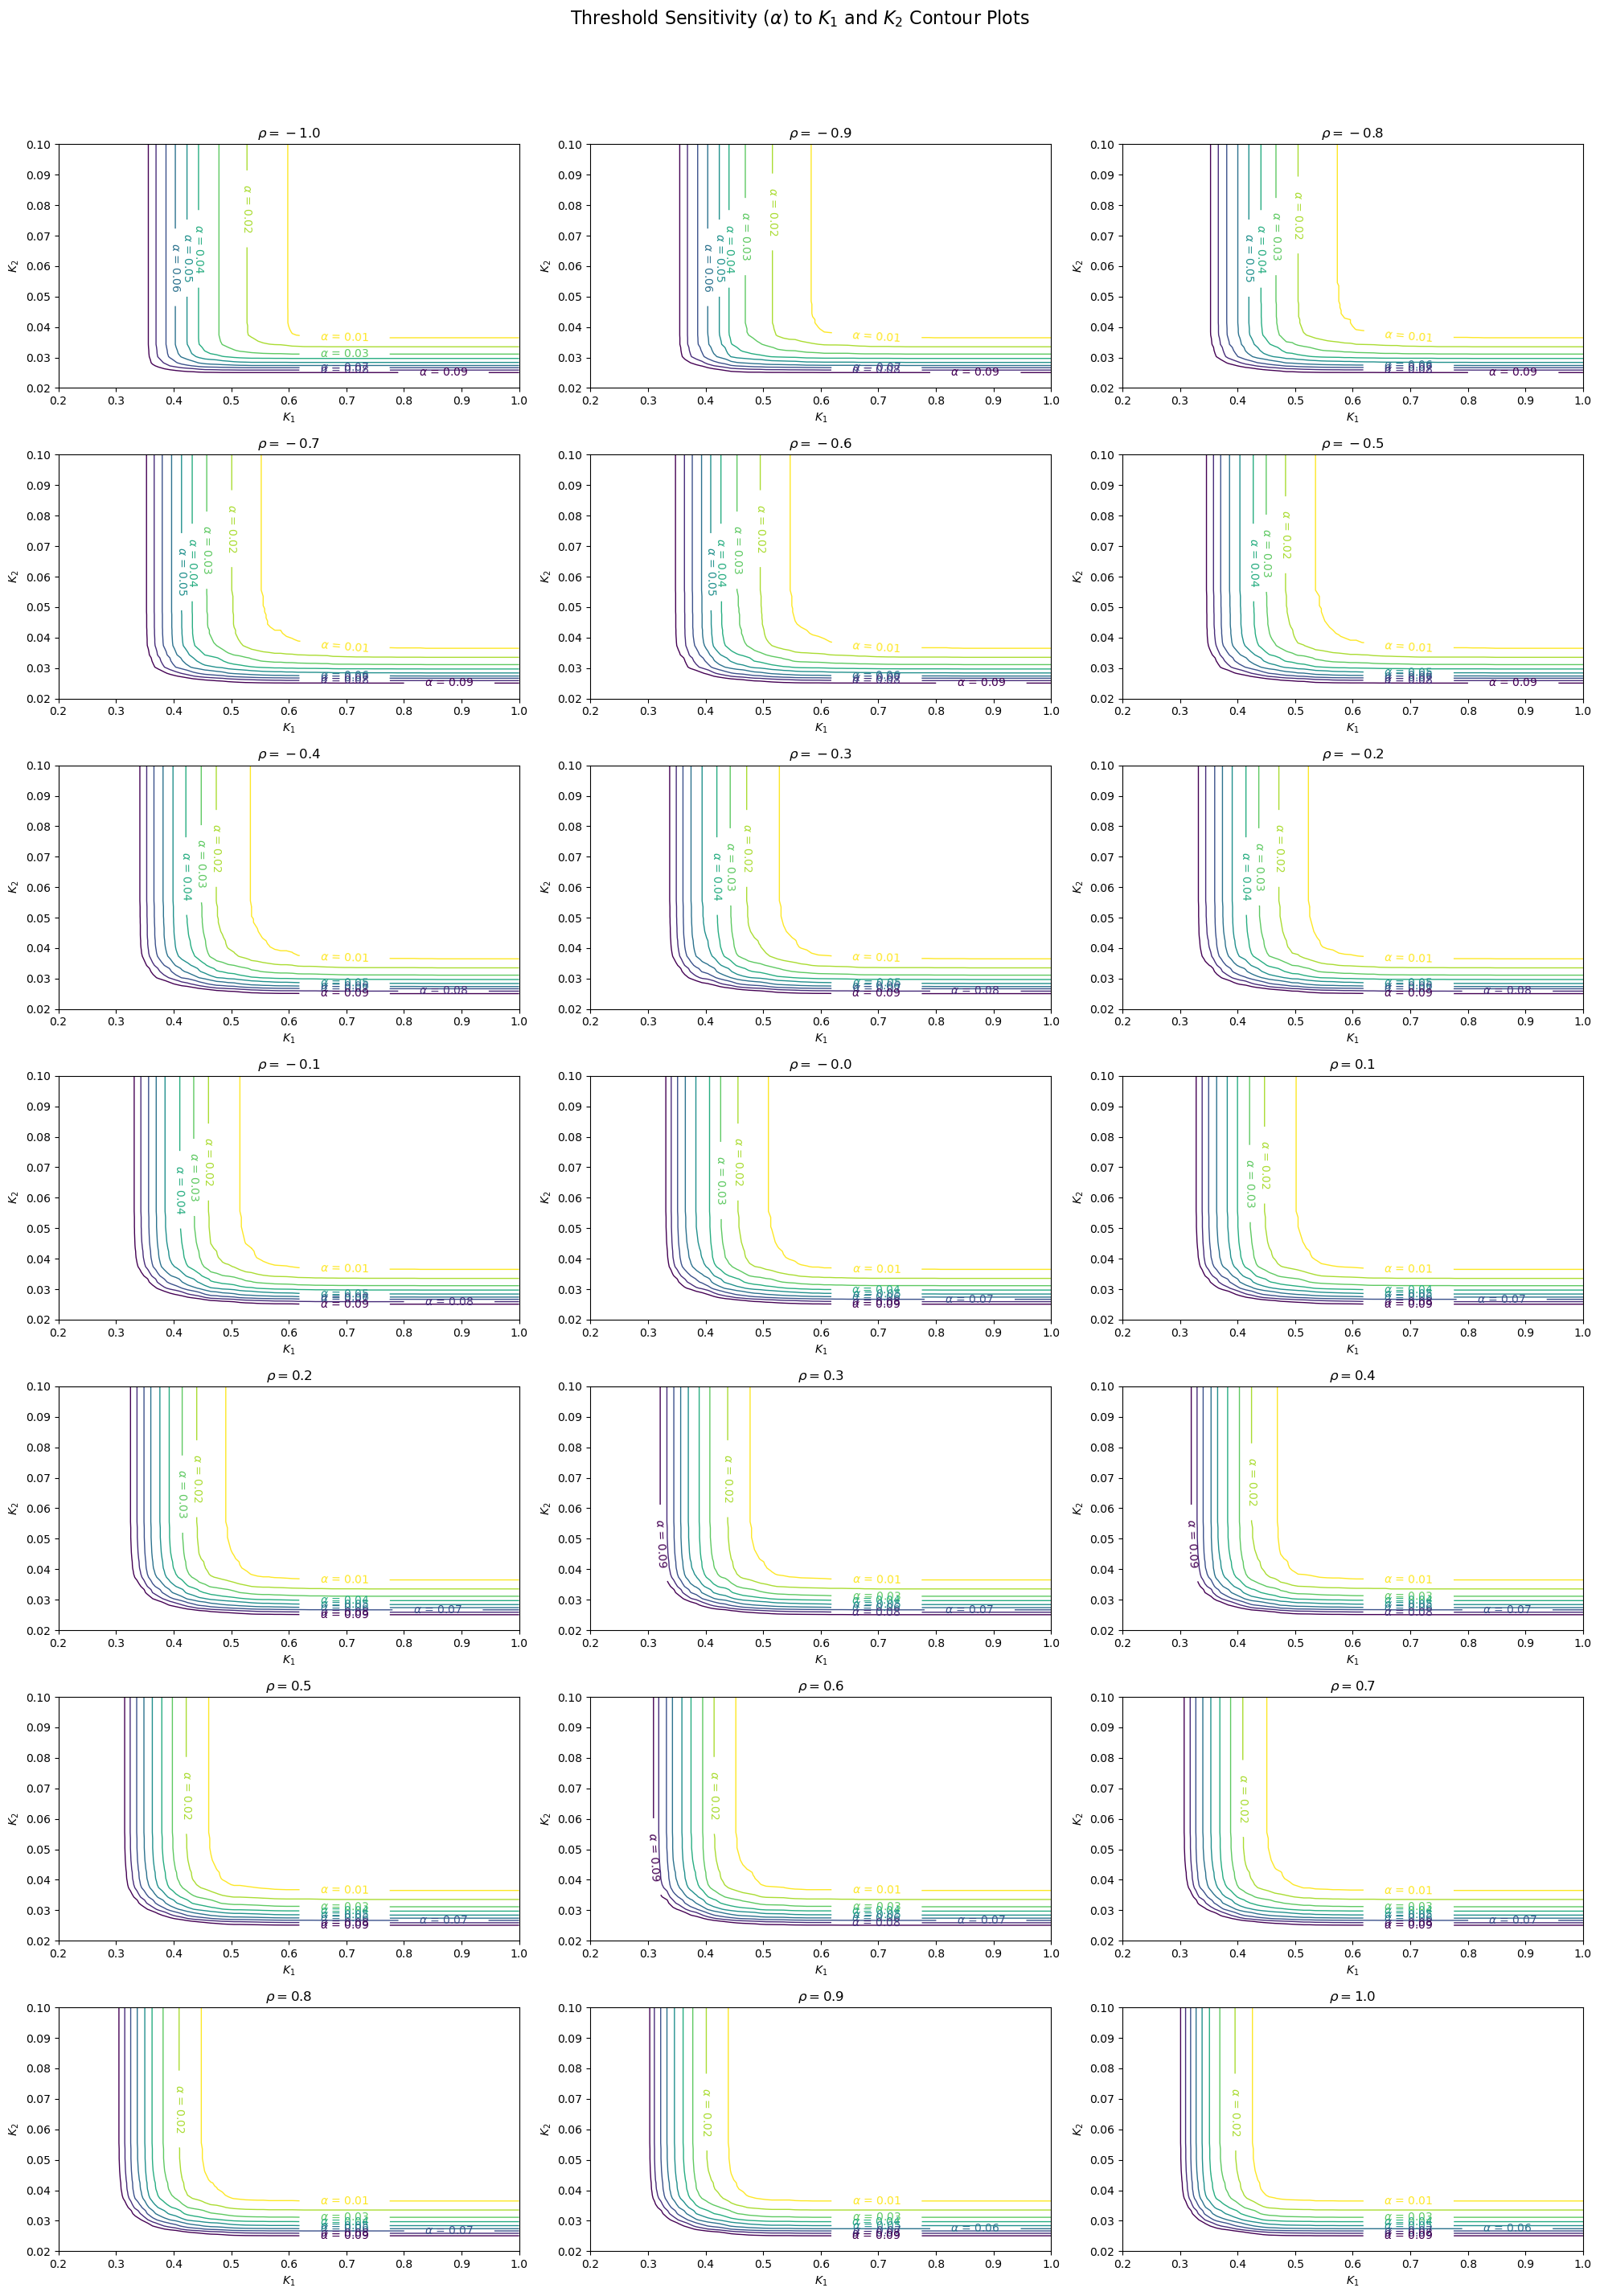

In [9]:
# Buy-and-Hold portfolio with two thresholds test

# Define the threshold values for K1 and K2
threshold_k1_values = np.linspace(0, 1.0, 100)
threshold_k2_values = np.linspace(0, 0.1, 100)

# Define the range of correlation coefficients (rho)
rho_values = np.arange(-1, 1.1, 0.1)

# Define the alpha values for contour plot highlighting
alpha_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

# Calculate the base threshold R(t) only once
threshold_r_t_base = np.log1p(s0) + (mu - (1/2 * np.sqrt(theta)**2)) * np.linspace(0, T, n_steps+1)

# Create a grid of subplots for the contour plots
fig, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()  # Flatten the axes array for easier indexing
fig.suptitle('Threshold Sensitivity ($\\alpha$) to $K_{1}$ and $K_{2}$ Contour Plots', fontsize=16)

# Loop over rho values and create subplots
for idx, rho in enumerate(rho_values):
    # Correlated Brownian motion increments for dW2
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * dZ

    # Simulate the Geometric Brownian Motion paths using dW2
    s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
    log_s_paths_gbm = np.log1p(s_paths_gbm)  # Logarithm of the simulated asset price paths

    # Calculate the base threshold for R(t) - k1 only once
    threshold_r_t_base = np.log1p(s0) + (mu - (1/2 * np.sqrt(theta)**2)) * np.linspace(0, T, n_steps + 1)

    # Calculate the proportion of paths below the thresholds for each combination of k1 and k2
    threshold_k1_k2_matrix = calculate_prop_k1_k2(
        log_s_paths=log_s_paths_gbm,          # Logarithm of simulated asset price paths
        cir_paths=cir_vol_paths,              # CIR process paths for stochastic volatility
        threshold_k1_values=threshold_k1_values,  # Array of k1 threshold values
        threshold_k2_values=threshold_k2_values,  # Array of k2 threshold values
        threshold_r_t_base=threshold_r_t_base,    # Base threshold R(t) - k1
        mean_vol=theta                           # Mean reversion level for volatility
    )

    # Create mesh grid for contour plot
    X, Y = np.meshgrid(threshold_k1_values, threshold_k2_values)
    Z = threshold_k1_k2_matrix.T

    # Plotting
    ax = axes[idx]  # Select the current subplot
    contour_highlight = ax.contour(X, Y, Z, levels=alpha_values, cmap='viridis_r', linewidths=1)
    ax.clabel(contour_highlight, inline=1, fontsize=10, fmt={val: f'$\\alpha$ = {val:.2f}' for val in alpha_values})
    
    ax.set_xlabel('$K_1$')  # Set x-axis label
    ax.set_ylabel('$K_2$')  # Set y-axis label
    ax.set_title(f'$\\rho = {rho:.1f}$')  # Set title with rho value
    ax.set_xlim(0.2, 1)  # Set x-axis limits
    ax.set_ylim(0.02, 0.1)  # Set y-axis limits

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent overlap
plt.show()  # Show the plot

In [72]:
# Generate arrays for rho and K_threshold
rho = np.linspace(-1, 1, 21)  # Create an array of rho values from -1 to 1
threshold_k1_values = np.linspace(0, 1.0, 100)  # 100 values from 0 to 1.0 for k1
threshold_k2_values = np.linspace(0, 0.2, 100)  # 100 values from 0 to 0.1 for k2
target_alpha_values = [0.001, 0.01, 0.05, 0.1] # define the target alpha values
alpha_percentiles = target_alpha_values * 100 # convert alpha values to percentiles for VaR calculation

# Initialize array to store results for multiple rho and K_threshold values
multiple_k_thresholds = np.zeros((len(rho), len(threshold_k1_values), len(threshold_k2_values)))
multiple_rho_s_paths = np.zeros((len(rho), n_paths, n_steps+1))
portfolio_value_T_matrix = np.zeros((len(rho), n_paths))

# Initialize a dictionary to store results
results_dict = {alpha: [] for alpha in target_alpha_values}

# Calculate the threshold value R_t based on initial conditions
threshold_r_t = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps+1) * dt) + log_s0 

# Loop over each rho value
for i, rho_value in enumerate(rho):
    # Calculate correlated Brownian motion dW2 using the current rho value
    dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
    # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
    s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
    log_s_paths_gbm = np.log1p(s_paths_gbm)  # Logarithm of the simulated asset price paths
    
    # Calculate the proportion of paths below the thresholds for each combination of k1 and k2
    threshold_k1_k2_matrix = calculate_prop_k1_k2(
        log_s_paths=log_s_paths_gbm,          # Logarithm of simulated asset price paths
        cir_paths=cir_vol_paths,              # CIR process paths for stochastic volatility
        threshold_k1_values=threshold_k1_values,  # Array of k1 threshold values
        threshold_k2_values=threshold_k2_values,  # Array of k2 threshold values
        threshold_r_t_base=threshold_r_t_base,    # Base threshold R(t) - k1
        mean_vol=theta                           # Mean reversion level for volatility
    )
    # Store the results (proportions below threshold) in the multiple_k_thresholds array
    multiple_k_thresholds[i, :, :] = threshold_k1_k2_matrix
    
    # Store the asset prices with different corelation values for further analysis
    multiple_rho_s_paths[i, :, :] = s_paths_gbm
    
    # Compute the portfolio value at time T for each path
    portfolio_value_T_matrix[i,:] = buy_hold_portfolio_payoff_T(s=s_paths_gbm, s0=s0, r=risk_free_rate, T=T)
    

In [136]:
# Define the ranges and target alphas
rho_values = np.linspace(-1, 1, 21)  # Create an array of rho values from -1 to 1

# Select alpha value
alpha = 0.05  # Use the alpha value 0.01 for this computation

# Initialize a dictionary to store results
results_dict = {alpha: []}  # Dictionary to store results for the selected alpha

for idx, rho_val in enumerate(rho_values):
    k1_k2_mat = multiple_k_thresholds[idx, :, :]  # Extract k1 and k2 thresholds for current rho

    # Calculate the absolute differences between the matrix elements and alpha
    diff = np.abs(k1_k2_mat - alpha)

    # Find the minimum difference
    min_diff = np.min(diff)

    # Find all indices where the difference equals the minimum difference
    indices = np.argwhere(diff == min_diff)

    # Get the closest values using the indices
    closest_values = k1_k2_mat[indices[:, 0], indices[:, 1]]

    new_risk_measure_array = []
    var_risk_measure_array = []
    for i in range(len(indices)):
        k1_thresh_val = threshold_k1_values[indices[i, 0]]  # Get k1 threshold value
        k2_thresh_val = threshold_k2_values[indices[i, 1]]  # Get k2 threshold value

        # Create masks for the conditions (above k1 threshold and below k2 threshold)
        above_rt_mask_k1 = np.zeros((n_paths, n_steps + 1), dtype=bool)
        below_vt_mask_k2 = np.zeros((n_paths, n_steps + 1), dtype=bool)
        for j in range(n_paths):  # Loop through each path
            above_rt_mask_k1[j, :] = np.log1p(multiple_rho_s_paths[idx, j, :]) > (threshold_r_t - k1_thresh_val)
            below_vt_mask_k2[j, :] = cir_vol_paths[j, :] < theta + k2_thresh_val

        # Combine masks to get a single mask where both conditions are satisfied
        combined_mask = above_rt_mask_k1 & below_vt_mask_k2
        valid_indices = np.sum(combined_mask, axis=1) == n_steps + 1  # Find paths satisfying both conditions

        # Compute new risk measure and VaR measure
        new_risk_measure_array.append(V_phi_omega_T(portfolio_value_T_matrix[idx, valid_indices]))
        var_risk_measure_array.append(V_phi_VaR(portfolio_value_T_matrix[idx, :], a=alpha*100))

    # Store the results in the dictionary
    results_dict[alpha].append({
        'rho': rho_val,
        'k1_thresh_vals': threshold_k1_values[indices[:, 0]].tolist(),
        'k2_thresh_vals': threshold_k2_values[indices[:, 1]].tolist(),
        'new_risk_measure_array': new_risk_measure_array,
        'var_risk_measure_array': var_risk_measure_array
    })

# Print the results using tabulate
results = results_dict[alpha]
print(f"Results for alpha = {alpha}:")
table_data = []
for result in results:
    for k1, k2, new_risk, var_risk in zip(result['k1_thresh_vals'], result['k2_thresh_vals'], result['new_risk_measure_array'], result['var_risk_measure_array']):
        table_data.append([result['rho'], k1, k2, new_risk, var_risk])
print(tabulate(table_data, headers=['rho', 'k1', 'k2', 'new_risk_measure', 'var_risk_measure'], tablefmt='grid'))


Results for alpha = 0.05:
+-------+----------+-----------+--------------------+--------------------+
|   rho |       k1 |        k2 |   new_risk_measure |   var_risk_measure |
+=======+==========+===========+====================+====================+
|  -1   | 0.424242 | 0.0343434 |            37.2839 |            33.1012 |
+-------+----------+-----------+--------------------+--------------------+
|  -0.9 | 0.424242 | 0.0383838 |            37.7099 |            32.8382 |
+-------+----------+-----------+--------------------+--------------------+
|  -0.9 | 0.424242 | 0.040404  |            37.7099 |            32.8382 |
+-------+----------+-----------+--------------------+--------------------+
|  -0.9 | 0.424242 | 0.0424242 |            37.7099 |            32.8382 |
+-------+----------+-----------+--------------------+--------------------+
|  -0.9 | 0.424242 | 0.0444444 |            37.7099 |            32.8382 |
+-------+----------+-----------+--------------------+--------------------+

In [10]:
# # Generate arrays for rho and K_threshold
# rho = np.linspace(-1, 1, 21)  # Create an array of rho values from -1 to 1
# threshold_k1_values = np.linspace(0, 1.0, 100)  # 100 values from 0 to 1.0 for k1
# threshold_k2_values = np.linspace(0, 0.2, 100)  # 100 values from 0 to 0.1 for k2
# target_alpha_values = [0.001, 0.01, 0.05, 0.1] # define the target alpha values
# alpha_percentiles = target_alpha_values * 100 # convert alpha values to percentiles for VaR calculation

# # Initialize array to store results for multiple rho and K_threshold values
# #multiple_k_thresholds = np.zeros((len(rho), len(threshold_k1_values), len(threshold_k2_values)))

# # Initialize a dictionary to store results
# results_dict = {alpha: [] for alpha in target_alpha_values}

# # Calculate the threshold value R_t based on initial conditions
# threshold_r_t = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps+1) * dt) + log_s0 

# # Loop over each rho value
# for i, rho_value in enumerate(rho):
#     # Calculate correlated Brownian motion dW2 using the current rho value
#     dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
#     # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
#     s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
#     log_s_paths_gbm = np.log1p(s_paths_gbm)  # Logarithm of the simulated asset price paths
    
#     # Calculate the proportion of paths below the thresholds for each combination of k1 and k2
#     threshold_k1_k2_matrix = calculate_prop_k1_k2(
#         log_s_paths=log_s_paths_gbm,          # Logarithm of simulated asset price paths
#         cir_paths=cir_vol_paths,              # CIR process paths for stochastic volatility
#         threshold_k1_values=threshold_k1_values,  # Array of k1 threshold values
#         threshold_k2_values=threshold_k2_values,  # Array of k2 threshold values
#         threshold_r_t_base=threshold_r_t_base,    # Base threshold R(t) - k1
#         mean_vol=theta                           # Mean reversion level for volatility
#     )
#     # Store the results (proportions below threshold) in the multiple_k_thresholds array
#     #multiple_k_thresholds[i, :, :] = threshold_k1_k2_matrix
    
#     # Calculate the call option and their corresponding delta values using the Black-Scholes formula
#     call_price, call_delta = call_option_price(s_paths_gbm, strike, risk_free_rate, dividend, dt_seq, long_term_vol)

#     # Create synthetic delta hedged call option prices
#     call_delta_hedged_prices, _ = call_option_delta_hedge_process(number_of_shares=number_of_shares, hedging_frequency=hedging_frequency,
#                                     risk_free_rate=risk_free_rate, s_paths=s_paths_gbm, 
#                                     option_prices=call_price, option_deltas=call_delta, 
#                                     n_steps=n_steps, n_paths=n_paths)
    
#     # Compute the portfolio value at time T for each path
#     call_portfolio_value_T = long_call_portfolio_payoff_T(hedged_p=call_delta_hedged_prices, call_p=call_price, r=risk_free_rate, t=T)

#     # Iterate over target alpha values
#     for idx, target_alpha in enumerate(target_alpha_values):
#         # Calculate absolute differences between alpha values in the matrix and the target alpha
#         abs_diff = np.abs(threshold_k1_k2_matrix - target_alpha)
        
#         # Find the row and column indices of the minimum absolute difference
#         min_indices = np.unravel_index(np.argmin(abs_diff, axis=None), abs_diff.shape)
        
#         # Get the corresponding k1 and k2 values using the row and column indices
#         k1_value = threshold_k1_values[min_indices[0]]
#         k2_value = threshold_k2_values[min_indices[1]]
        
#         # Calculate new measure (v_phi) for the selected paths
#         above_rt_mask_k1 = log_s_paths_gbm > (threshold_r_t - k1_value)
#         below_vt_mask_k2 = cir_vol_paths < k2_value
        
#         # Combine masks: both conditions need to be met
#         combined_mask = np.logical_and(above_rt_mask_k1, below_vt_mask_k2)

#         # Check which rows (paths) have all elements above the combined threshold (ignoring the last step)
#         all_above_combined_mask_rows = np.all(combined_mask[:, :-1], axis=1)
#         indices_all_above_combined_mask = np.where(all_above_combined_mask_rows)[0]

#         if len(indices_all_above_combined_mask) > 0:
#             rho_phi = V_phi_omega_T(call_portfolio_value_T[indices_all_above_combined_mask])
#             var_5_percent = V_phi_VaR(call_portfolio_value_T[indices_all_above_combined_mask], alpha_percentiles[idx])
        
#         else:
#             rho_phi = np.nan  # Handle case where no paths are above the combined threshold
#             var_5_percent = np.nan

#         # Append rho, k1, k2, new_measure, and VaR values to the results dictionary
#         results_dict[target_alpha].append((rho_value, k1_value, k2_value, rho_phi, var_5_percent))

# # Create a list of dictionaries for each result to form the DataFrame
# table_rows = []
# for alpha, values in results_dict.items():
#     for (rho_value, k1_value, k2_value, new_measure, var_5_percent) in values:
#         table_rows.append({
#             'alpha': alpha,
#             'rho': rho_value,
#             'k1': k1_value,
#             'k2': k2_value,
#             'new_measure': np.round(new_measure, 5),
#             'VaR': np.round(var_5_percent, 5)
#         })

# # Create a DataFrame from the table rows
# df = pd.DataFrame(table_rows)

# # Print the DataFrame as a table
# print(df.to_string(index=False))


In [11]:
# # Generate arrays for rho and K_threshold
# rho = np.linspace(-1, 1, 21)  # Create an array of rho values from -1 to 1
# threshold_k1_values = np.linspace(0, 1.0, 100)  # 100 values from 0 to 1.0 for k1
# threshold_k2_values = np.linspace(0, 0.1, 100)  # 100 values from 0 to 0.1 for k2

# # Calculate the threshold value R_t based on initial conditions
# threshold_r_t = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps+1) * dt) + log_s0 

# # Initialize array to store results for multiple rho and K_threshold values
# multiple_k_thresholds = np.zeros((len(rho), len(threshold_k1_values), len(threshold_k2_values)))

# # Define the target alpha values
# target_alpha_values = [0.001, 0.01, 0.05, 0.1]

# # Convert alpha values to percentiles for VaR calculation
# alpha_percentiles = target_alpha_values * 100

# # Initialize a dictionary to store results
# results_dict = {alpha: [] for alpha in target_alpha_values}

# # Loop over each rho value
# for i, rho_value in enumerate(rho):
#     # Calculate correlated Brownian motion dW2 using the current rho value
#     dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
#     # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
#     s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
#     log_s_paths_gbm = np.log1p(s_paths_gbm)  # Logarithm of the simulated asset price paths

#     # Calculate the proportion of paths below the thresholds for each combination of k1 and k2
#     threshold_k1_k2_matrix = calculate_prop_k1_k2(
#         log_s_paths=log_s_paths_gbm,          # Logarithm of simulated asset price paths
#         cir_paths=cir_vol_paths,              # CIR process paths for stochastic volatility
#         threshold_k1_values=threshold_k1_values,  # Array of k1 threshold values
#         threshold_k2_values=threshold_k2_values,  # Array of k2 threshold values
#         threshold_r_t_base=threshold_r_t_base,    # Base threshold R(t) - k1
#         mean_vol=theta                           # Mean reversion level for volatility
#     )
#     # Store the results (proportions below threshold) in the multiple_k_thresholds array
#     multiple_k_thresholds[i, :, :] = threshold_k1_k2_matrix
    
#     # Iterate over target alpha values
#     for idx, target_alpha in enumerate(target_alpha_values):
#         # Calculate absolute differences between alpha values in the matrix and the target alpha
#         abs_diff = np.abs(threshold_k1_k2_matrix - target_alpha)
        
#         # Find the row and column indices of the minimum absolute difference
#         min_indices = np.unravel_index(np.argmin(abs_diff, axis=None), abs_diff.shape)
        
#         # Get the corresponding k1 and k2 values using the row and column indices
#         k1_value = threshold_k1_values[min_indices[0]]
#         k2_value = threshold_k2_values[min_indices[1]]
        
#         # Append rho, k1, and k2 values to the results dictionary
#         results_dict[target_alpha].append((rho_value, k1_value, k2_value))
    
# # Print the results dictionary
# for alpha, values in results_dict.items():
#     print(f"For alpha value {alpha}:")
#     for rho_value, k1_value, k2_value in values:
#         print(f"  rho: {rho_value}, k1: {k1_value}, k2: {k2_value}")


In [12]:
# for i in range(len(rho)):
#     rho_value, k1, k2 = results_dict[0.1][i]
# #print(rho_value, k1, k2)

#     # Calculate correlated Brownian motion dW2 using the current rho value
#     dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
#     # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
#     s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
#     log_s_paths_gbm = np.log1p(s_paths_gbm)  # Logarithm of the simulated asset price paths
#     portfolio_value_T = buy_hold_portfolio_payoff_T(s=s_paths_gbm, s0=s0, r=risk_free_rate, T=T)

#     above_rt_mask_k1 = np.zeros((n_paths, n_steps+1), dtype=bool)
#     below_vt_mask_k2 = np.zeros((n_paths, n_steps+1), dtype=bool)
#     for j in range(n_paths):
#         above_rt_mask_k1[j, :] = np.log1p(s_paths_gbm[j,:]) > (threshold_r_t - k1)
#         below_vt_mask_k2[j :] = cir_vol_paths[j,:] < k2

#     # Combine masks to get a single mask where both conditions are satisfied
#     combined_mask = above_rt_mask_k1 & below_vt_mask_k2
#     all_above_combined_mask_rows = np.sum(combined_mask, axis=1) > 0

#     print(f"new: {-np.min(portfolio_value_T[all_above_combined_mask_rows])}")
#     print(f"var: {-np.percentile(portfolio_value_T, 0.1*100)}")

In [13]:
# # Initialize dictionaries to store results
# alpha_to_new_measure_dict = {}
# alpha_to_VaR_dict = {}

# # Initialize a list to store the table rows
# table_rows = []

# # Loop through each value of rho
# for i, rho_value in enumerate(rho):
#     new_measures = []  # List to store new measures for different alpha values
#     VaR_measure = []   # List to store VaR measures for different alpha values

#     # Calculate correlated Brownian motion dW2 using the current rho value
#     dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
#     # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
#     s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
#     log_s_paths_gbm = np.log1p(s_paths_gbm)  # Logarithm of the simulated asset price paths

#     # # Calculate the call option and their corresponding delta values using the Black-Scholes formula
#     # call_price, call_delta = call_option_price(s_paths_gbm, strike, risk_free_rate, dividend, dt_seq, long_term_vol)

#     # # Create synthetic delta hedged call option prices
#     # call_delta_hedged_prices, _ = call_option_delta_hedge_process(number_of_shares=number_of_shares, hedging_frequency=hedging_frequency,
#     #                                 risk_free_rate=risk_free_rate, s_paths=s_paths_gbm, 
#     #                                 option_prices=call_price, option_deltas=call_delta, 
#     #                                 n_steps=n_steps, n_paths=n_paths)

#     # Compute the portfolio value at time T for each path
#     portfolio_value_T = buy_hold_portfolio_payoff_T(s=s_paths_gbm, s0=s0, r=risk_free_rate, T=T)

#     # Iterate over each alpha value
#     for alpha, alpha_percentile in zip(target_alpha_values, alpha_percentiles):
#         # Retrieve the corresponding k1 and k2 thresholds for the current rho and alpha
#         k1_thresh, k2_thresh = results_dict[alpha][i][1:3]

#         # Create masks for the conditions (above k1 threshold and below k2 threshold)
#         above_rt_mask_k1 = np.zeros((n_paths, n_steps+1), dtype=bool)
#         below_vt_mask_k2 = np.zeros((n_paths, n_steps+1), dtype=bool)
#         for j in range(n_paths):
#             above_rt_mask_k1[j, :] = np.log1p(s_paths_gbm[j,:]) > (threshold_r_t - k1_thresh)
#             below_vt_mask_k2[j :] = cir_vol_paths[j,:] < k2_thresh

#         # Combine masks to get a single mask where both conditions are satisfied
#         combined_mask = above_rt_mask_k1 & below_vt_mask_k2


#         # Create masks for the conditions
#         # # Mask where log(S(t)) is above the k1 threshold
#         # above_rt_mask_k1 = log_s_paths_gbm > (threshold_r_t - k1_thresh)
        
#         # # Mask where CIR paths are below the k2 threshold
#         # below_vt_mask_k2 = cir_vol_paths < k2_thresh

#         # # Combine masks: both conditions need to be met
#         # combined_mask = above_rt_mask_k1 + below_vt_mask_k2

#         all_above_combined_mask_rows = np.sum(combined_mask, axis=1) > 0
        
#         # Check which rows (paths) have all elements above the combined threshold (ignoring the last step)
#         #all_above_combined_mask_rows = np.all(combined_mask[:, :-1], axis=1)
#         #indices_all_above_combined_mask = np.where(all_above_combined_mask_rows)[0]
#        # print(indices_all_above_combined_mask)

#         # Calculate new measure (v_phi)
#         if len(indices_all_above_combined_mask) > 0:
#             rho_phi = V_phi_omega_T(portfolio_value_T[all_above_combined_mask_rows])
#             #print(f"path_{i} with rho_phi {rho_phi}")
#         else:
#             rho_phi = np.nan  # Handle case where no paths are above the combined threshold

#         # Calculate the VaR measure
#         var_5_percent = V_phi_VaR(portfolio_value_T, alpha_percentile)

#         # Append the new measure and VaR measure to the respective lists
#         new_measures.append(np.round(rho_phi, 5))
#         VaR_measure.append(np.round(var_5_percent, 5))

#         # Append the results to the table rows
#         table_rows.append({
#             'rho': rho_value,
#             'alpha': alpha,
#             'k1': k1_thresh,
#             'k2': k2_thresh,
#             'new_measure': np.round(rho_phi, 5),
#             'VaR': np.round(var_5_percent, 5)
#         })

#     # Store the alpha-to-new-measure and alpha-to-VaR mappings for the current rho
#     alpha_to_new_measure_dict[i] = dict(zip(alpha_values, new_measures))
#     alpha_to_VaR_dict[i] = dict(zip(alpha_values, VaR_measure))

# # Create a DataFrame from the table rows
# df = pd.DataFrame(table_rows)

# # Print the DataFrame as a table
# print(df.to_string(index=False))


In [14]:
# # Generate arrays for rho and K_threshold
# rho = np.linspace(-1, 1, 21)  # Create an array of rho values from -1 to 1
# threshold_k1_values = np.linspace(0, 1.0, 100)  # 100 values from 0 to 1.0 for k1
# threshold_k2_values = np.linspace(0, 0.1, 100)  # 100 values from 0 to 0.1 for k2

# # Calculate the threshold value R_t based on initial conditions
# threshold_r_t = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps+1) * dt) + log_s0 

# # Define the target alpha values
# target_alpha_values = [0.001, 0.01, 0.05, 0.1]

# # Convert alpha values to percentiles for VaR calculation
# alpha_percentiles = [alpha * 100 for alpha in target_alpha_values]

# # Initialize dictionaries to store results
# results_dict = {alpha: [] for alpha in target_alpha_values}
# alpha_to_new_measure_dict = {}
# alpha_to_VaR_dict = {}

# # Initialize a list to store the table rows
# table_rows = []

# # Loop through each value of rho
# for i, rho_value in enumerate(rho):
#     # Calculate correlated Brownian motion dW2 using the current rho value
#     dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
#     # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
#     s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
#     log_s_paths_gbm = np.log1p(s_paths_gbm)  # Logarithm of the simulated asset price paths

#     # Compute the portfolio value at time T for each path
#     portfolio_value_T = buy_hold_portfolio_payoff_T(s=s_paths_gbm, s0=s0, r=risk_free_rate, T=T)

#     # Calculate the proportion of paths below the thresholds for each combination of k1 and k2
#     threshold_k1_k2_matrix = calculate_prop_k1_k2(
#         log_s_paths=log_s_paths_gbm,          # Logarithm of simulated asset price paths
#         cir_paths=cir_vol_paths,              # CIR process paths for stochastic volatility
#         threshold_k1_values=threshold_k1_values,  # Array of k1 threshold values
#         threshold_k2_values=threshold_k2_values,  # Array of k2 threshold values
#         threshold_r_t_base=threshold_r_t,    # Base threshold R(t) - k1
#         mean_vol=theta                           # Mean reversion level for volatility
#     )

#     # Iterate over each alpha value
#     for alpha, alpha_percentile in zip(target_alpha_values, alpha_percentiles):
#         # Calculate absolute differences between alpha values in the matrix and the target alpha
#         abs_diff = np.abs(threshold_k1_k2_matrix - alpha)
        
#         # Find the row and column indices of the minimum absolute difference
#         min_indices = np.unravel_index(np.argmin(abs_diff, axis=None), abs_diff.shape)
        
#         # Get the corresponding k1 and k2 values using the row and column indices
#         k1_thresh = threshold_k1_values[min_indices[0]]
#         k2_thresh = threshold_k2_values[min_indices[1]]

#         # Create masks for the conditions (above k1 threshold and below k2 threshold)
#         rep_r_t = threshold_r_t - k1_thresh
#         above_rt_mask_k1 = log_s_paths_gbm > rep_r_t
#         below_vt_mask_k2 = cir_vol_paths < k2_thresh
#         combined_mask = above_rt_mask_k1 & below_vt_mask_k2
#         all_above_combined_mask_rows = np.any(combined_mask[:, :-1], axis=1)

#         # Calculate new measure (v_phi)
#         if np.any(all_above_combined_mask_rows):
#             rho_phi = V_phi_omega_T(portfolio_value_T[all_above_combined_mask_rows])
#         else:
#             rho_phi = np.nan  # Handle case where no paths are above the combined threshold

#         # Calculate the VaR measure
#         var_5_percent = V_phi_VaR(portfolio_value_T, alpha_percentile)

#         # Append the new measure and VaR measure to the respective lists
#         new_measures.append(np.round(rho_phi, 5))
#         VaR_measure.append(np.round(var_5_percent, 5))

#         # Append the results to the table rows
#         table_rows.append({
#             'rho': rho_value,
#             'alpha': alpha,
#             'k1': k1_thresh,
#             'k2': k2_thresh,
#             'new_measure': np.round(rho_phi, 5),
#             'VaR': np.round(var_5_percent, 5)
#         })

#     # Store the alpha-to-new-measure and alpha-to-VaR mappings for the current rho
#     alpha_to_new_measure_dict[i] = dict(zip(target_alpha_values, new_measures))
#     alpha_to_VaR_dict[i] = dict(zip(target_alpha_values, VaR_measure))

# # Create a DataFrame from the table rows
# df = pd.DataFrame(table_rows)

# # Print the DataFrame as a table
# print(df.to_string(index=False))


In [15]:
# # Generate arrays for rho and K_threshold
# rho = np.linspace(-1, 1, 21)  # Create an array of rho values from -1 to 1
# threshold_k1_values = np.linspace(0, 1.0, 100)  # 100 values from 0 to 1.0 for k1
# threshold_k2_values = np.linspace(0, 0.1, 100)  # 100 values from 0 to 0.1 for k2

# # Calculate the threshold value R_t based on initial conditions
# threshold_r_t = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps+1) * dt) + log_s0 

# # Define the target alpha values
# target_alpha_values = [0.001, 0.01, 0.05, 0.1]

# # Convert alpha values to percentiles for VaR calculation
# alpha_percentiles = [alpha * 100 for alpha in target_alpha_values]

# # Initialize dictionaries to store results
# alpha_to_new_measure_dict = {}
# alpha_to_VaR_dict = {}

# # Initialize a list to store the table rows
# table_rows = []

# # Loop through each value of rho
# for i, rho_value in enumerate(rho):
#     new_measures = []  # List to store new measures for different alpha values
#     VaR_measure = []   # List to store VaR measures for different alpha values

#     # Calculate correlated Brownian motion dW2 using the current rho value
#     dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
#     # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
#     s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
#     log_s_paths_gbm = np.log1p(s_paths_gbm)  # Logarithm of the simulated asset price paths

#     # Compute the portfolio value at time T for each path
#     portfolio_value_T = buy_hold_portfolio_payoff_T(s=s_paths_gbm, s0=s0, r=risk_free_rate, T=T)

#     # Iterate over each alpha value
#     for alpha, alpha_percentile in zip(target_alpha_values, alpha_percentiles):
#         # Retrieve the corresponding k1 and k2 thresholds for the current rho and alpha
#         k1_thresh, k2_thresh = results_dict[alpha][i][1:3]

#         # Create masks for the conditions (above k1 threshold and below k2 threshold)
#         rep_r_t = threshold_r_t - k1_thresh
#         above_rt_mask_k1 = log_s_paths_gbm > rep_r_t
#         below_vt_mask_k2 = cir_vol_paths < k2_thresh
#         combined_mask = above_rt_mask_k1 & below_vt_mask_k2
#         all_above_combined_mask_rows = np.any(combined_mask[:, :-1], axis=1)

#         # Calculate new measure (v_phi)
#         if np.any(all_above_combined_mask_rows):
#             rho_phi = V_phi_omega_T(portfolio_value_T[all_above_combined_mask_rows])
#         else:
#             rho_phi = np.nan  # Handle case where no paths are above the combined threshold

#         # Calculate the VaR measure
#         var_5_percent = V_phi_VaR(portfolio_value_T, alpha_percentile)

#         # Append the new measure and VaR measure to the respective lists
#         new_measures.append(np.round(rho_phi, 5))
#         VaR_measure.append(np.round(var_5_percent, 5))

#         # Append the results to the table rows
#         table_rows.append({
#             'rho': rho_value,
#             'alpha': alpha,
#             'k1': k1_thresh,
#             'k2': k2_thresh,
#             'new_measure': np.round(rho_phi, 5),
#             'VaR': np.round(var_5_percent, 5)
#         })

#     # Store the alpha-to-new-measure and alpha-to-VaR mappings for the current rho
#     alpha_to_new_measure_dict[i] = dict(zip(target_alpha_values, new_measures))
#     alpha_to_VaR_dict[i] = dict(zip(target_alpha_values, VaR_measure))

# # Create a DataFrame from the table rows
# df = pd.DataFrame(table_rows)

# # Print the DataFrame as a table
# print(df.to_string(index=False))


In [16]:
# # Define the target alpha values
# target_alpha_values = [0.001, 0.01, 0.05, 0.1]

# # Convert alpha values to percentiles for VaR calculation
# alpha_percentiles = target_alpha_values * 100

# # Initialize a dictionary to store results
# results_dict = {alpha: [] for alpha in target_alpha_values}

# # Loop over each matrix
# for i, matrix in enumerate(multiple_k_thresholds):
#     # Iterate over target alpha values
#     for idx, target_alpha in enumerate(target_alpha_values):
#         # Calculate absolute differences between alpha values in the matrix and the target alpha
#         abs_diff = np.abs(matrix - target_alpha)
        
#         # Find the row and column indices of the minimum absolute difference
#         min_indices = np.unravel_index(np.argmin(abs_diff, axis=None), abs_diff.shape)
        
#         # Get the corresponding rho, k1, and k2 values using the row and column indices
#         rho_value = rho[i]
#         k1_value = threshold_k1_values[min_indices[0]]
#         k2_value = threshold_k2_values[min_indices[1]]
        
#         # Append rho, k1, and k2 values to the results dictionary
#         results_dict[target_alpha].append((np.round(rho_value, 5), np.round(k1_value, 5), np.round(k2_value, 5)))

# # Print the results dictionary
# # for alpha, values in results_dict.items():
# #     print(f"For alpha value {alpha}:")
# #     for rho_value, k1_value, k2_value in values:
# #         print(f"  rho: {rho_value}, k1: {k1_value}, k2: {k2_value}")

# # # Loop through each value of rho
# # for i, rho_value in enumerate(rho):
# #     new_measures = []  # List to store new measures for different alpha values
# #     VaR_measure = []   # List to store VaR measures for different alpha values

# #     # Calculate correlated Brownian motion dW2 using the current rho value
# #     dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
# #     # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
# #     s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
    
# #     # Compute the portfolio value at time T for each path
# #     portfolio_value_T = buy_hold_portfolio_payoff_T(s=s_paths_gbm, s0=s0, r=risk_free_rate, T=T)

# #     # Iterate over each alpha value
# #     for alpha, alpha_percentile in zip(target_alpha_values, alpha_percentiles):
# #         # Retrieve the corresponding k1 threshold for the current rho and alpha
# #         k1_thresh = results_dict[i][alpha]